In [1]:
import os
from symmer.symplectic.base import PauliwordOp
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from symmer.approximate import MPOOp, find_groundstate_quimb, coefflist_to_complex

In [2]:
base = os.path.split(os.path.dirname(os.getcwd()))[0]
test_dir = os.path.join(base, 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')

In [3]:
print(test_dir)

/home/vinulw/Documents/PhD/code/symmer-main/tests


In [4]:
filename = 'H4_STO-3G_SINGLET_JW.json'
problemName = os.path.splitext(filename)[0]

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

In [5]:
problemName

'H4_STO-3G_SINGLET_JW'

## Generating MPO using the Pauli strings sequentially

In [6]:
hamiltonian_dict = data_dict['hamiltonian']
pstrings, coefflist = zip(*data_dict['hamiltonian'].items())

coeffs = coefflist_to_complex(coefflist)

In [7]:
MPO = MPOOp(pstrings, coeffs)

Want to compare the output from the mpo generation with the exact matrix generated from PauliWordOp. 

In [8]:
#    # Code to do the same conversion with Pauli WordOp
wordop = PauliwordOp.from_dictionary(hamiltonian_dict)

print("Contracting exact mpo...")
mpo_matrix = MPO.to_matrix

print("Converting wordop to matrix...")
wordop_matrix = wordop.to_sparse_matrix.toarray()

print("")

print("Exact MPO construction equivalent to Matrix: ", np.allclose(mpo_matrix, wordop_matrix))

Contracting exact mpo...
Converting wordop to matrix...

Exact MPO construction equivalent to Matrix:  True


Then will compare MPO generation including a truncation to a given bond dimension $D$. To measure the effect of the truncation we use the trace distance measure:

$$
\text{trace}((\rho - \sigma)^2)
$$

In [9]:
def trace_distance(m1, m2):
    return np.trace((m1 - m2) * np.conj((m1 - m2).T))

Dmaxs = [16, 32, 64, 128]

tdists = []
print("Trace distance for given bond dimension")
for D in Dmaxs:
    mpo = MPOOp(pstrings, coeffs, Dmax=D)
    mpo_matrix = mpo.to_matrix
    tdists.append(trace_distance(wordop_matrix, mpo_matrix))
    print(f"    {D}: {tdists[-1]}")

Trace distance for given bond dimension
    16: (15.866046789260023+0j)
    32: (2.222349305574701+0j)
    64: (1.9856804945739513e-13+0j)
    128: (2.6123087696407196e-14+0j)


/home/vinulw/.pyenv/versions/3.8.14/envs/sym-main/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


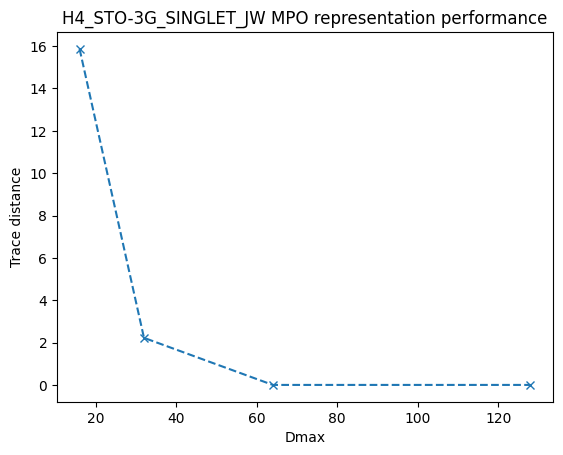

In [10]:
plt.plot(Dmaxs, tdists, 'x--')
plt.title(f"{problemName} MPO representation performance")
plt.xlabel("Dmax")
plt.ylabel("Trace distance")
plt.show()

## Comparing approximate MPO groundstate to exact

Finding the groundstate using DMRG for small qubit numbes ($n\leq10$)

In [11]:
from quimb.tensor.tensor_1d import MatrixProductOperator
from quimb.tensor.tensor_dmrg import DMRG2
from symmer.symplectic import QuantumState
from symmer.utils import exact_gs_energy

In [12]:
filtered_files = [   # all the 10 qubit files
    "B+_STO-3G_SINGLET_JW.json",
    "C_STO-3G_TRIPLET_BK.json",
    "C_STO-3G_TRIPLET_JW.json",
    "O_STO-3G_TRIPLET_JW.json",
    "Be_STO-3G_SINGLET_JW.json",
    "N_STO-3G_QUARTET_BK.json",
    "Li_STO-3G_DOUBLET_BK.json",
    "H2_6-31G_SINGLET_BK.json",
    "Be_STO-3G_SINGLET_BK.json",
    "HeH+_3-21G_SINGLET_BK.json",
    "H2_6-31G_SINGLET_JW.json",
    "N_STO-3G_QUARTET_JW.json",
    "B+_STO-3G_SINGLET_BK.json",
    "B_STO-3G_DOUBLET_BK.json",
    "H3+_STO-3G_SINGLET_JW.json",
    "Li_STO-3G_DOUBLET_JW.json",
    "H2_3-21G_SINGLET_BK.json",
    "H2_3-21G_SINGLET_JW.json",
    "H3+_STO-3G_SINGLET_BK.json",
    "B_STO-3G_DOUBLET_JW.json",
    "H4_STO-3G_SINGLET_JW.json",
    "HeH+_3-21G_SINGLET_JW.json",
    "H4_STO-3G_SINGLET_BK.json",
]

data_dicts = []

for f in filtered_files:
    with open(os.path.join(ham_data_dir, f), 'r') as infile:
        data_dicts.append(json.load(infile))


In [13]:
D = 128 # set some arbitrary Dmax
for fl, dct in zip(tqdm(filtered_files), data_dicts):
    tqdm.write(f'Calculating properties for {fl}...')
    pstrings, coefflist = zip(*dct['hamiltonian'].items())
    coeffs = coefflist_to_complex(coefflist)
    H_op = PauliwordOp.from_dictionary(dct['hamiltonian'])
    
    # Make MPO
    mpo = MPOOp(pstrings, coeffs, D)
    tqdm.write("   Generated MPO...")

    dmrg_state = find_groundstate_quimb(mpo)
    tqdm.write("   Found DMRG ground state...")

    gs_energy, gs_vec = exact_gs_energy(H_op.to_sparse_matrix)
    gs_state = QuantumState.from_array(gs_vec).cleanup(zero_threshold=1e-5)

    gs_overlap = np.linalg.norm(gs_state.dagger * dmrg_state)

    gs_energy = -1*np.linalg.norm(gs_state.dagger * H_op * gs_state)
    dmrg_energy = -1*np.linalg.norm(dmrg_state.dagger * H_op * dmrg_state)
    hf_energy = dct['data']['calculated_properties']['HF']['energy']

    tqdm.write(f"   GS Overlap: {gs_overlap}")
    tqdm.write(f"   GS Energy: {gs_energy}")
    tqdm.write(f"   HF Energy: {hf_energy}")
    tqdm.write(f"   DMRG Energy: {dmrg_energy}")
    tqdm.write("")


  0%|          | 0/23 [00:00<?, ?it/s]

Calculating properties for B+_STO-3G_SINGLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.1698392667170201
   GS Energy: -24.189264917101653
   HF Energy: -23.948470366408024
   DMRG Energy: -24.188987373312816

Calculating properties for C_STO-3G_TRIPLET_BK.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.3242035965173091
   GS Energy: -37.21873355064026
   HF Energy: -37.198392563731566
   DMRG Energy: -37.21866925918811

Calculating properties for C_STO-3G_TRIPLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.267716156789063
   GS Energy: -37.21873355063961
   HF Energy: -37.198392563731566
   DMRG Energy: -37.21740283482861

Calculating properties for O_STO-3G_TRIPLET_JW.json...
   Generated MPO...
   Found DMRG ground state...
   GS Overlap: 0.07479310382966219
   GS Energy: -73.80415023326813
   HF Energy: -73.80415023325587
   DMRG Energy: -73.80346365599006

Calculating properties for Be_